# Projekt Autoenkoder
Indeks: 145317

Wymagania:
- stworzenie sieci neuronowej typu autoencoder
- dane wejściowe to obrazy czarno-białe (1 kanał)
- dane wyjściowe to obrazy kolorowe (3 kanały)
- badanie różnych rozmiarów sieci neuronowej
- badanie wpływu poszczególnych elementów regularyzacji na wynik:
  - wpływ parametru momentum oraz rozmiaru batcha przy wykorzystaniu batch normalization
  - wpływ dropout rate
  - wpływ weight decay

Zrealizowane przy wykorzystaniu bibliotek:
- Pytorch — Tworzenie i nauka sieci neuronowej.
- Matplotlib -- Wizualizacja.
- cv2 - open-cv -- Obróbka obrazów.

Wykorzystany dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.


In [124]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K

import cv2
import numpy as np
import matplotlib.pyplot as plt


## Sprawdzenie dostępności GPU

In [125]:
import tensorflow as tf

tf.config.list_physical_devices('GPU') and 'GPU is available' or "GPU is not available"

'GPU is available'

## Załadowanie bazy obrazów Cifar100 oraz wykonanie preprocesów.
- Baza obrazów:
  - [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.
- Preprocesy:
  - Zamiana przestrzeni z 1-255 python-int na 0-1 float32.
  - Zamiana obrazu kolorowego na obraz szary.
  - Rozszerzenie kształtu obrazu szarego na kształt kompatybilny z wejściem sieci.

In [126]:
def rgb2gray(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def load_datasets():
  print("Loading train dataset...")
  print("Loading test dataset...")
  (y_train, _), (y_test, _) = cifar100.load_data()
  print("Preparing train dataset...")
  y_train = y_train.astype('float32') / 255
  x_train = np.expand_dims([rgb2gray(x) for x in y_train], axis=3)
  print("Preparing test dataset...")
  y_test = y_test.astype('float32') / 255
  x_test = np.expand_dims([rgb2gray(x) for x in y_test], axis=3)
  print("Finished.")
  return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_datasets()

Loading train dataset...
Loading test dataset...
Preparing train dataset...
Preparing test dataset...
Finished.


## Prezentacja przykładowych obrazów z datasetu.

In [127]:
def compare(original, grayscale=None):
  if grayscale is None: grayscale = rgb2gray(original)

  figure, axes = plt.subplots(1, 2)
  axes[0].set_title("Original")
  axes[0].grid(False)
  axes[0].set_axis_off()
  axes[0].imshow(original)
  axes[1].set_title("Grayscale")
  axes[1].grid(False)
  axes[1].set_axis_off()
  axes[1].imshow(grayscale, cmap='gray')

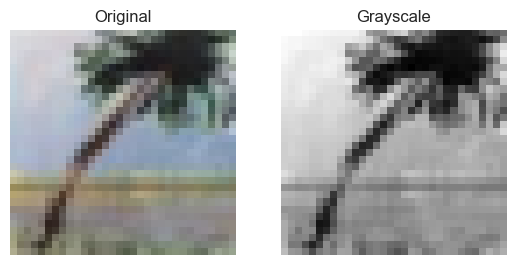

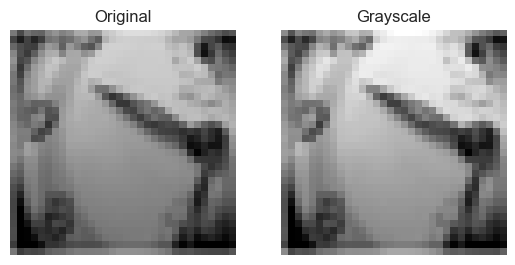

In [128]:
index = np.random.randint(2, len(y_train) - 1)
for original in y_train[index - 2:index]: compare(original)

### Prezentacja kolażu obrazów.

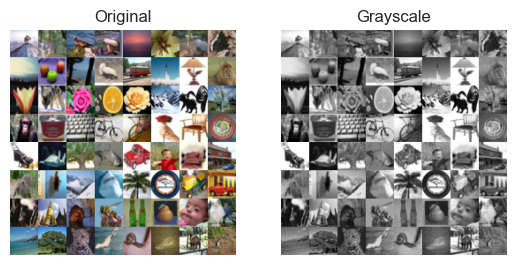

In [129]:
def square_collage(images, size: int = 8):
  (_, rows, cols, channels) = images.shape
  collage = images[:size * size]
  collage = collage.reshape((size, size, rows, cols, channels))
  return np.vstack([*map(np.hstack, collage)])

compare(square_collage(y_test), square_collage(x_test))

## Konstrukcja modelu sieci autoencoder.
- Konstrukcja sieci jst sparametryzowana o możliwość wprowadzenia:
  - use_normalization: bool -- batch normalization.
  - use_dropout: bool | float -- wykorzystanie dropout'u.

### Wartości stałe dla sieci.

In [135]:
input_shape = (32, 32, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256, 512]

### Podsumowanie Modelu 'Decoder'.

In [136]:
inputs = Input(shape=input_shape, name='encoder-input')
x = inputs
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=2,
             activation='relu',
             padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder-input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 512)         1180160   
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               5245

### Podsumowanie Modelu 'Encoder'.

In [138]:
latent_inputs = Input(shape=(latent_dim,), name='decoder-input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in reversed(layer_filters):
  x = Conv2DTranspose(filters=filters,
                      kernel_size=3,
                      strides=2,
                      activation='relu',
                      padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=2,
                          strides=1,
                          activation='sigmoid',
                          padding='same',
                          name='decoder-output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_3 (Dense)             (None, 2048)              526336    
                                                                 
 reshape_3 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 4, 4, 512)        2359808   
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 8, 8, 256)        1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 128)      2950

### Model summary

In [139]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder-input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               2074368   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         4435651   
                                                                 
Total params: 6,510,019
Trainable params: 6,510,019
Non-trainable params: 0
_________________________________________________________________


### Training callbacks
- ReduceLROnPlateau - reduces lr by given value 0.1**0.5 every 3 epochs without improvement.
- ModalCheckpoint - saves model to given path every improved epoch.

In [140]:

# reduce learning rate by sqrt(0.1) if the loss does not improve in 3 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath='models/coloring.{epoch:03d}.h5', monitor='val_loss', save_best_only=True,
                             verbose=True)

# Mean Square Error (MSE) loss function, Adam optimizer
callbacks = [lr_reducer, checkpoint]

### Training the network

In [141]:
def train_models(*models):
  histories = []
  for model in models:
    model.compile(loss='mse', optimizer='adam')
    histories.append(
      model.fit(x_train, y_train, validation_data=(x_test, y_test),
                epochs=30, batch_size=batch_size, callbacks=callbacks)
    )
  return histories
train_models(autoencoder)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0231
Epoch 1: val_loss improved from inf to 0.01762, saving model to models\coloring.001.h5
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0231 - val_loss: 0.0176 - lr: 0.0010
Epoch 2/30
1559/1563 [============================>.] - ETA: 0s - loss: 0.0168
Epoch 2: val_loss improved from 0.01762 to 0.01605, saving model to models\coloring.002.h5
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0168 - val_loss: 0.0161 - lr: 0.0010
Epoch 3/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 3: val_loss improved from 0.01605 to 0.01521, saving model to models\coloring.003.h5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0155 - val_loss: 0.0152 - lr: 0.0010
Epoch 4/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0147
Epoch 4: val_loss improved from 0.01521 to 0.01479, saving model to models\coloring.004.h5
1563/1

### Predict using autoencoder

In [142]:
predicted = autoencoder.predict(x_test)

313/313 [==============================] - 2s 4ms/step


## Results side by side
### Multiple

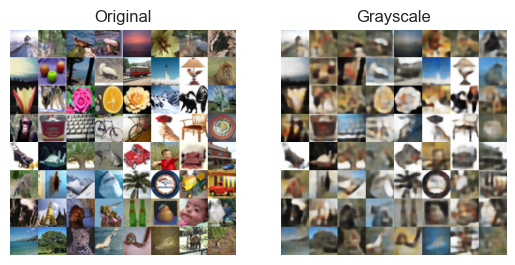

In [143]:
compare(square_collage(y_test), square_collage(predicted))

### Single Image

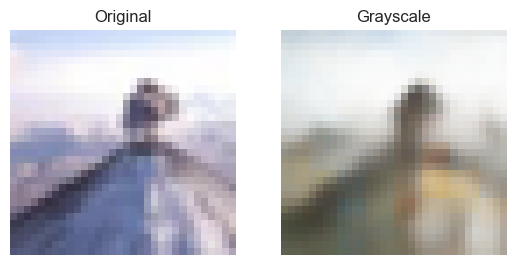

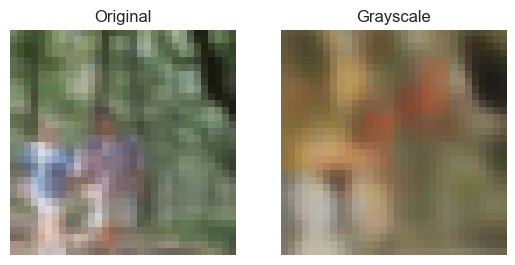

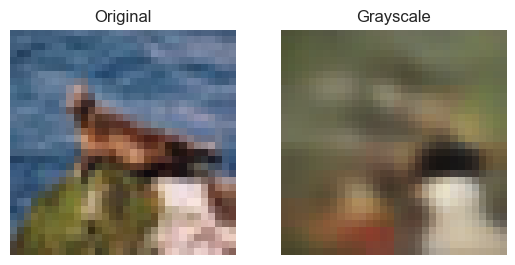

In [144]:
for (original, prediction) in zip(y_test[:3], predicted[:3]): compare(original, prediction)

## Badania wpływu parametrów na wyjście i parametry walidujące.

### Wpływ dropout rate.


### Wpływ weight decay.

### Wpływ rozmiaru batch normalization.